In [1]:
import pandas
import sklearn
import statsmodels
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### STEP 1 : 시계열 데이터 준비
#### Time Series 생성

In [2]:
import os

csv_path = os.getenv('HOME') + '/aiffel/stock_prediction/data/'
ts = pd.read_csv(csv_path+'005930.KS.csv', index_col='Date', parse_dates=True)
ts = ts['Close']
ts.head()

Date
2020-05-18    48800.0
2020-05-19    50300.0
2020-05-20    50000.0
2020-05-21    49950.0
2020-05-22    48750.0
Name: Close, dtype: float64

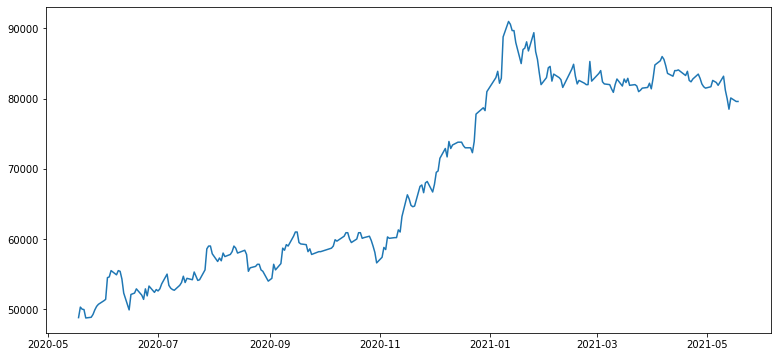

In [3]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 13, 6

plt.plot(ts)

- 그래프가 변화량이 크고 일정한 규칙이 보이지 않아 안정적인 시계열이라고 보기 어렵다.

### STEP 2 : 각종 전처리 수행
- 결측치 처리
- 로그 변환

In [4]:
# 결측치 처리

ts = ts.interpolate(method='time')
ts[ts.isna()] # 결측치 없음

Series([], Name: Close, dtype: float64)

In [5]:
# 로그 변환

ts_log = np.log(ts)
ts_log

Date
2020-05-18    10.795486
2020-05-19    10.825760
2020-05-20    10.819778
2020-05-21    10.818778
2020-05-22    10.794460
                ...    
2021-05-12    11.289782
2021-05-13    11.270854
2021-05-14    11.291031
2021-05-17    11.284769
2021-05-18    11.284769
Name: Close, Length: 250, dtype: float64

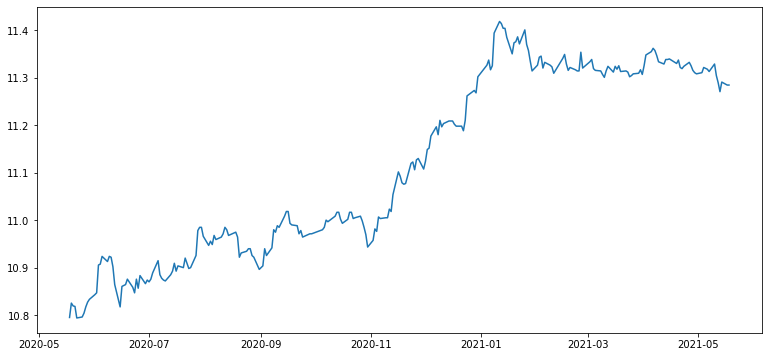

In [6]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 13, 6

plt.plot(ts_log)

### STEP 3 : 시계열 안정성 분석
- 정성적 그래프 분석
- 정량적 Augmented Dicky-Fuller Test
- 시계열 분해(Time Series Decomposition)
- Residual 안정성 확인

In [7]:
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화
    orig = plt.plot(timeseries,label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

In [8]:
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    dftest = adfuller(timeseries, autolag='AIC')  
    print('Results of Dickey-Fuller Test:')
    
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

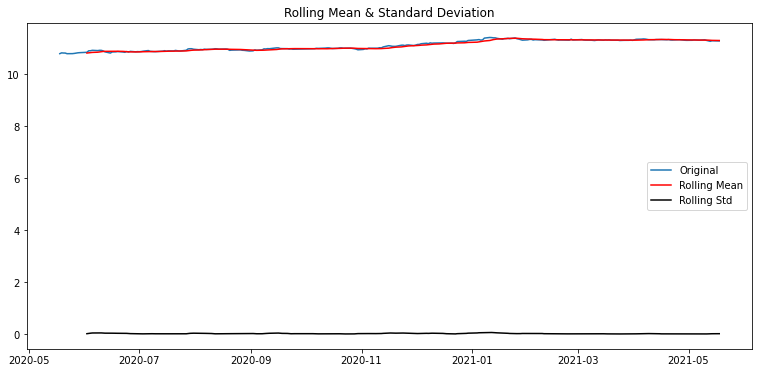

Results of Dickey-Fuller Test:
Test Statistic                  -1.383525
p-value                          0.590149
#Lags Used                       0.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64


In [9]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

- p-value 값이 충분히 0에 가깝게 나타나지 않아서 안정적인 시계열이라고 할 수 없다.

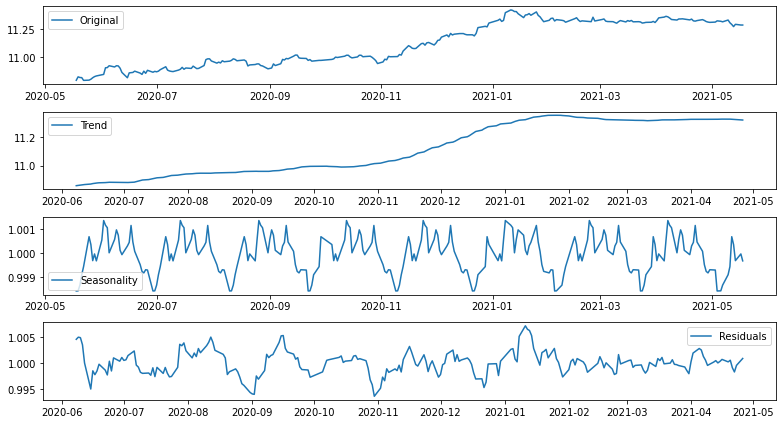

In [10]:
#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.rcParams["figure.figsize"] = (11,6)
plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [11]:
# Residual 안정성 확인

residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -6.187586e+00
p-value                        6.234854e-08
#Lags Used                     9.000000e+00
Number of Observations Used    2.100000e+02
Critical Value (1%)           -3.461879e+00
Critical Value (5%)           -2.875404e+00
Critical Value (10%)          -2.574159e+00
dtype: float64


- 시계열 분해 후에는 p-value 값이 거의 0에 가까워 안정적인 시계열이라고 할 수 있다.

### STEP 4 : 학습, 테스트 데이터셋 생성

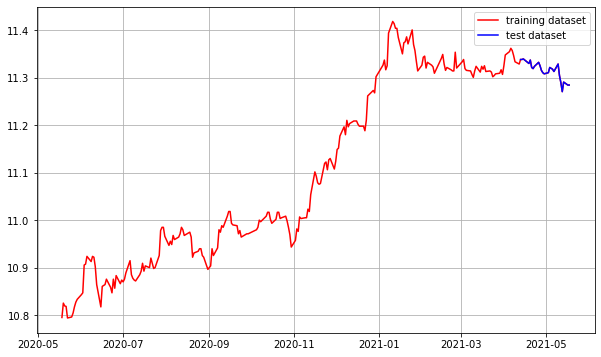

In [12]:
# 학습, 테스트 데이터셋 분리

train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

In [13]:
# 데이터셋 형태 확인
print(ts_log[:2])
print(train_data.shape)
print(test_data.shape)

Date
2020-05-18    10.795486
2020-05-19    10.825760
Name: Close, dtype: float64
(225,)
(25,)


### STEP 5 : 적정 ARIMA 모수 찾기
- ACF, PACF 그려보기 -> p,q 구하기
- 차분 안정성 확인 -> d 구하기

/opt/conda/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


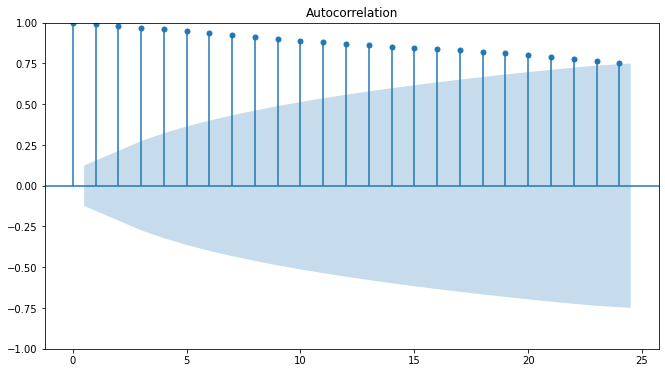

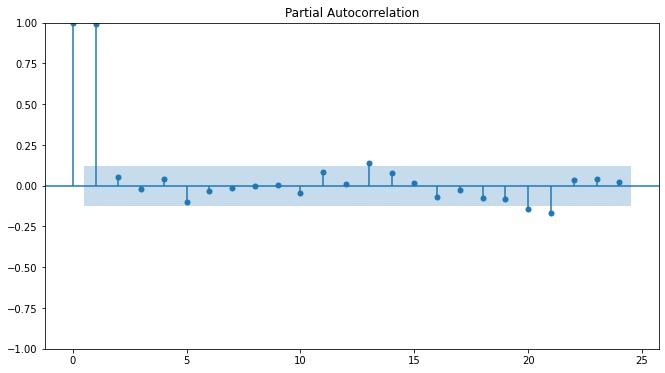

In [14]:
# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

- ACF는 1이 가장 크고 점점 작아지므로 q=1, PACF는 2 이후의 값에서 0에 가까워지므로 p=1가 가장 적절한 값이다.

Results of Dickey-Fuller Test:
Test Statistic                -1.553699e+01
p-value                        2.183738e-28
#Lags Used                     0.000000e+00
Number of Observations Used    2.480000e+02
Critical Value (1%)           -3.456996e+00
Critical Value (5%)           -2.873266e+00
Critical Value (10%)          -2.573019e+00
dtype: float64


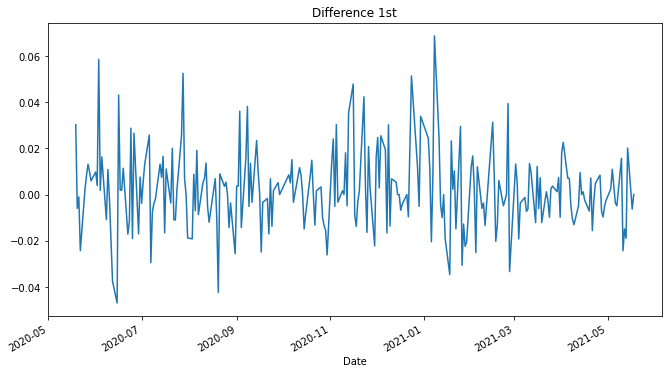

In [15]:
# 차분 안정성 확인 -> d 구하기

# 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

- 1차 차분 후 p-value가 충분히 작아 2차 차분을 구하지 않아도 될 듯하다.

### STEP 6 : ARIMA 모델 훈련과 테스트
- ARIMA 모델 빌드와 훈련
- 모델 테스트 및 플로팅
- 최종 예측 모델 정확도 측정(MAPE)

In [16]:
import warnings
warnings.filterwarnings('ignore')

from statsmodels.tsa.arima.model import ARIMA
# Build Model
model = ARIMA(train_data, order=(1, 1, 1))
fitted_m = model.fit() 

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  225
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 583.489
Date:                Thu, 29 Sep 2022   AIC                          -1160.979
Time:                        13:54:29   BIC                          -1150.744
Sample:                             0   HQIC                         -1156.847
                                - 225                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0126      2.094      0.006      0.995      -4.092       4.117
ma.L1          0.0237      2.102      0.011      0.991      -4.096       4.143
sigma2         0.0003   2.47e-05     12.936      0.0

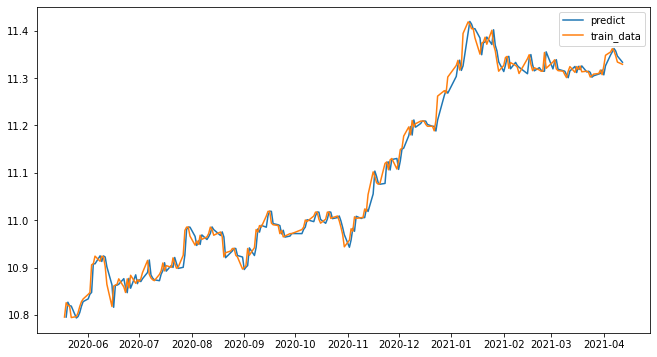

In [17]:
fitted_m = fitted_m.predict()
fitted_m = fitted_m.drop(fitted_m.index[0])
plt.plot(fitted_m, label='predict')
plt.plot(train_data, label='train_data')
plt.legend()

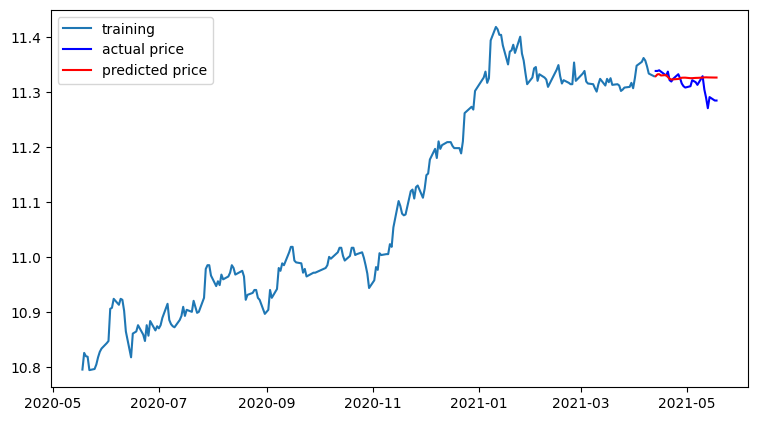

In [18]:
model = ARIMA(train_data, order=(14, 1, 0))  # p값을 14으로 테스트
fitted_m = model.fit() 
fc= fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(9,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [19]:
# 로그 변환하여 시계열 데이터 사용했으므로, 지수 변환해야 정확한 오차 계산 가능

from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  3005069.905300547
MAE:  1233.7924909538601
RMSE:  1733.5137453451434
MAPE: 1.53%


### STEP 7 : 다른 주식 종목 예측해 보기
### 1. Starbucks Coperation
STEP 1 : 시계열 데이터 준비

In [20]:
csv_path = os.getenv('HOME') + '/aiffel/stock_prediction/data/'
sbux = pd.read_csv(csv_path+'SBUX.csv', index_col='Date', parse_dates=True)
sbux = sbux['Close']
sbux

Date
2021-09-27    113.680000
2021-09-28    111.709999
2021-09-29    112.169998
2021-09-30    110.309998
2021-10-01    112.919998
                 ...    
2022-09-21     88.599998
2022-09-22     84.699997
2022-09-23     84.169998
2022-09-26     84.809998
2022-09-27     84.279999
Name: Close, Length: 253, dtype: float64

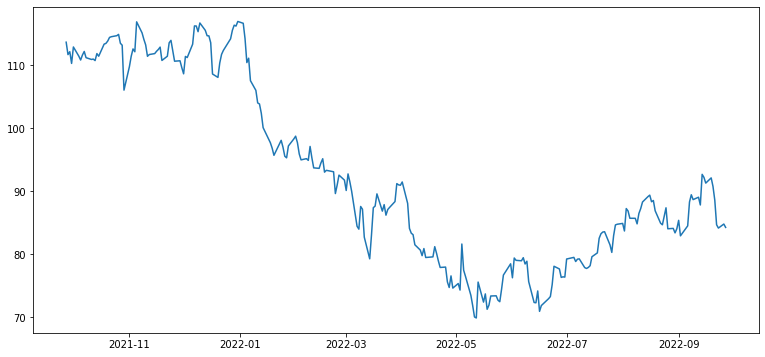

In [21]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 13, 6

plt.plot(sbux)

- 변화량이 많고 일정한 패턴이 보이지 않는 그래프로 안정적이지 않은 시계열이다.

STEP 2 : 각종 전처리 수행

In [22]:
# 결측치 처리

sbux = sbux.interpolate(method='time')
sbux[sbux.isna()] # 결측치 없음

Series([], Name: Close, dtype: float64)

In [23]:
# 로그 변환
sbux_log = np.log(sbux)
sbux_log

Date
2021-09-27    4.733387
2021-09-28    4.715906
2021-09-29    4.720016
2021-09-30    4.703295
2021-10-01    4.726680
                ...   
2022-09-21    4.484132
2022-09-22    4.439116
2022-09-23    4.432839
2022-09-26    4.440413
2022-09-27    4.434145
Name: Close, Length: 253, dtype: float64

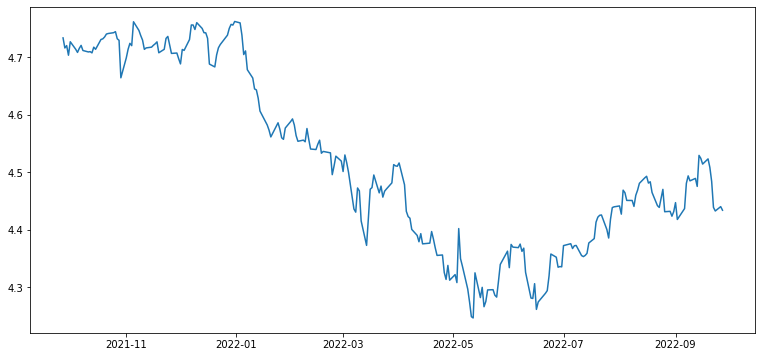

In [24]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 13, 6

plt.plot(sbux_log)

STEP 3 : 시계열 안정성 분석
- 정성적 그래프 분석
- 정량적 Augmented Dicky-Fuller Test
- 시계열 분해(Time Series Decomposition)
- Residual 안정성 확인

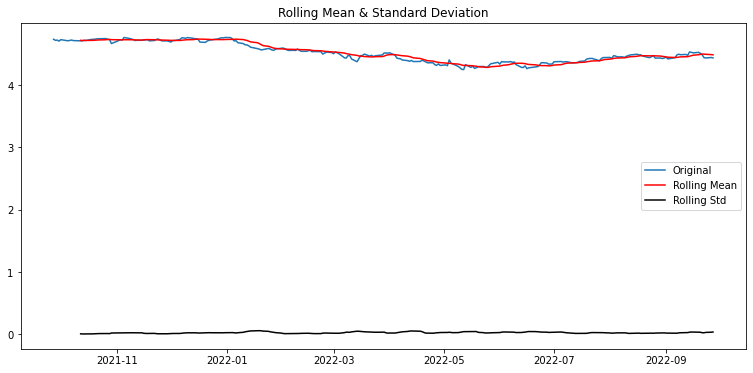

Results of Dickey-Fuller Test:
Test Statistic                  -1.485452
p-value                          0.540695
#Lags Used                       0.000000
Number of Observations Used    252.000000
Critical Value (1%)             -3.456569
Critical Value (5%)             -2.873079
Critical Value (10%)            -2.572919
dtype: float64


In [25]:
# 정성적 그래프 분석
plot_rolling_statistics(sbux_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(sbux_log)

- p-value 값이 0.5로 0에 가깝지 않으므로 귀무가설이 기각되지 않는다. = 시계열이 안정적이지 않을 확률이 높다.

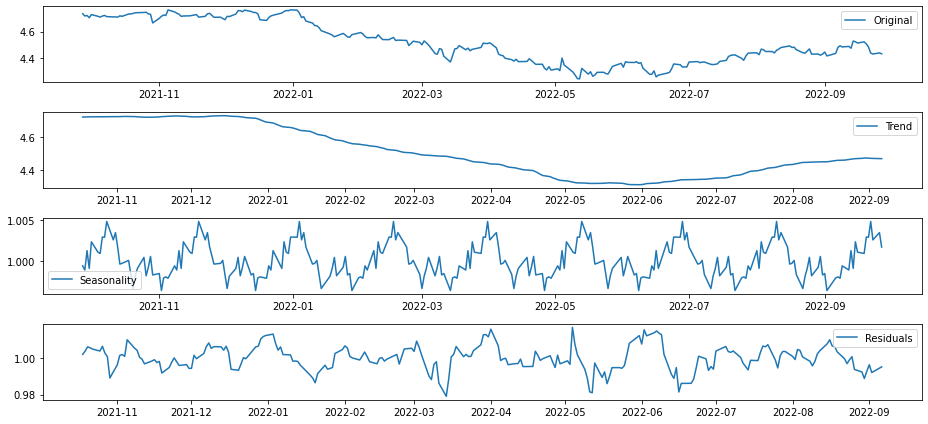

In [26]:
#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(sbux_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(sbux_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [27]:
# Residual 안정성 확인

residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -5.909415e+00
p-value                        2.660653e-07
#Lags Used                     1.100000e+01
Number of Observations Used    2.110000e+02
Critical Value (1%)           -3.461727e+00
Critical Value (5%)           -2.875337e+00
Critical Value (10%)          -2.574124e+00
dtype: float64


STEP 4 : 학습, 테스트 데이터셋 생성

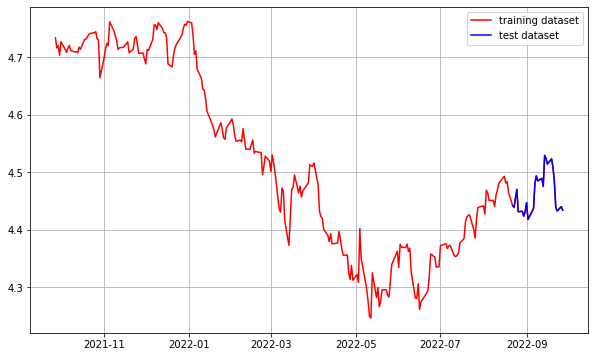

In [28]:
train_data, test_data = sbux_log[:int(len(sbux_log)*0.9)], sbux_log[int(len(sbux_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(sbux_log, c='r', label='training dataset')
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

STEP 5 : 적정 ARIMA 모수 찾기
- ACF, PACF 그려보기 -> p,q 구하기
- 차분 안정성 확인 -> d 구하기

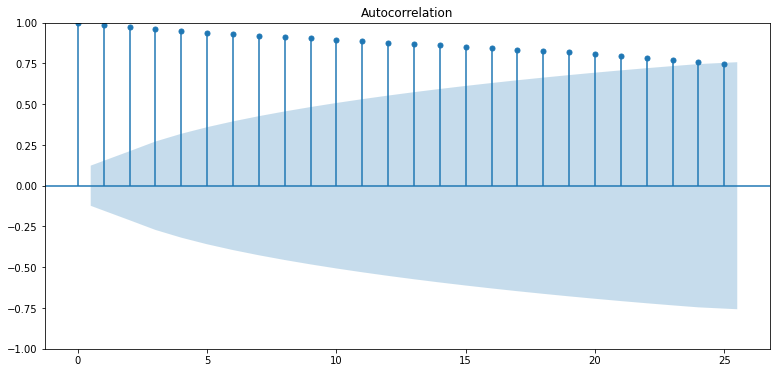

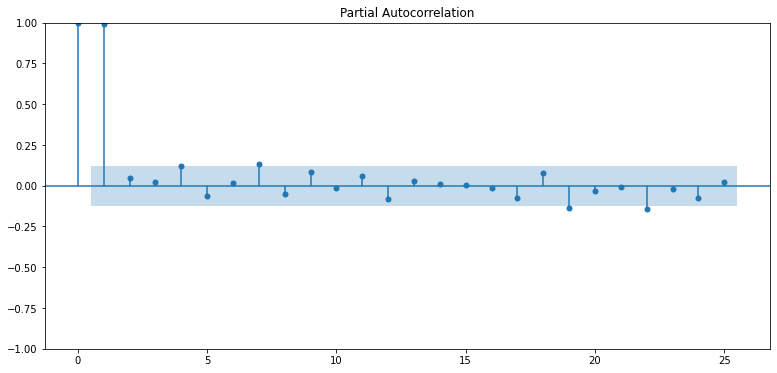

In [29]:
# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(sbux_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(sbux_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

- ACF가 1이 가장 크므로 q = 1, PACF는 1 제외하고는 0에 가까우므로 p = 1

Results of Dickey-Fuller Test:
Test Statistic                -1.620010e+01
p-value                        4.085704e-29
#Lags Used                     0.000000e+00
Number of Observations Used    2.510000e+02
Critical Value (1%)           -3.456674e+00
Critical Value (5%)           -2.873125e+00
Critical Value (10%)          -2.572944e+00
dtype: float64


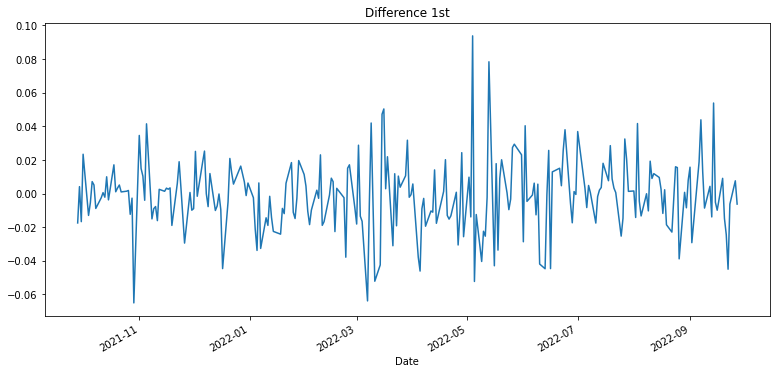

In [30]:
# 차분 안정성 확인 -> d 구하기

# 1차 차분 구하기
diff_1 = sbux_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

- 1차 차분만으로도 p-value가 충분히 작음

STEP 6 : ARIMA 모델 훈련과 테스트
- ARIMA 모델 빌드와 훈련
- 모델 테스트 및 플로팅
- 최종 예측 모델 정확도 측정(MAPE)

In [31]:
from statsmodels.tsa.arima.model import ARIMA
# Build Model
model = ARIMA(train_data, order=(1, 1, 1))  
fitted_m = model.fit() 

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  227
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 548.767
Date:                Thu, 29 Sep 2022   AIC                          -1091.533
Time:                        13:54:35   BIC                          -1081.272
Sample:                             0   HQIC                         -1087.392
                                - 227                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7306      0.300      2.434      0.015       0.142       1.319
ma.L1         -0.7855      0.275     -2.856      0.004      -1.325      -0.246
sigma2         0.0005   3.21e-05     14.201      0.0

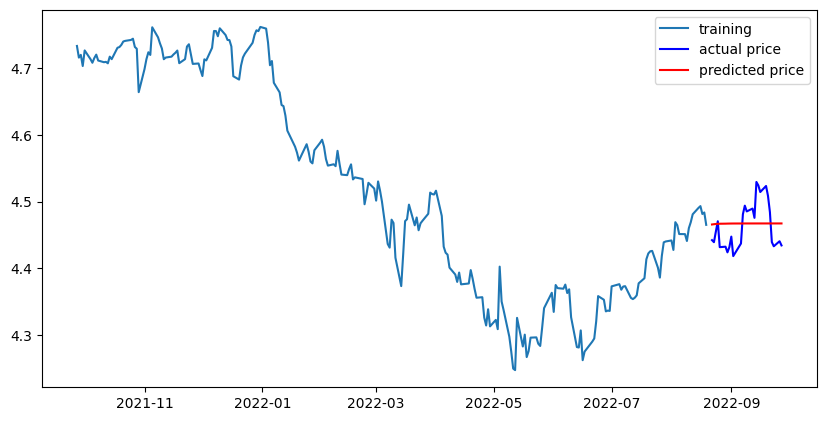

In [32]:
# Forecast
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [33]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  9.0641594574187
MAE:  2.699785047643919
RMSE:  3.010674252957085
MAPE: 3.09%


### 2. Hyundai Motor Company (005380.KS)
STEP 1 : 시계열 데이터 준비

In [34]:
csv_path = os.getenv('HOME') + '/aiffel/stock_prediction/data/'
hyundai = pd.read_csv(csv_path+'005380.KS.csv', index_col='Date', parse_dates=True)
hyundai = hyundai['Close']
hyundai

Date
2021-09-28    201500.0
2021-09-29    201500.0
2021-09-30    200000.0
2021-10-01    193500.0
2021-10-05    193500.0
                ...   
2022-09-22    193500.0
2022-09-23    190500.0
2022-09-26    182500.0
2022-09-27    186000.0
2022-09-28    179500.0
Name: Close, Length: 246, dtype: float64

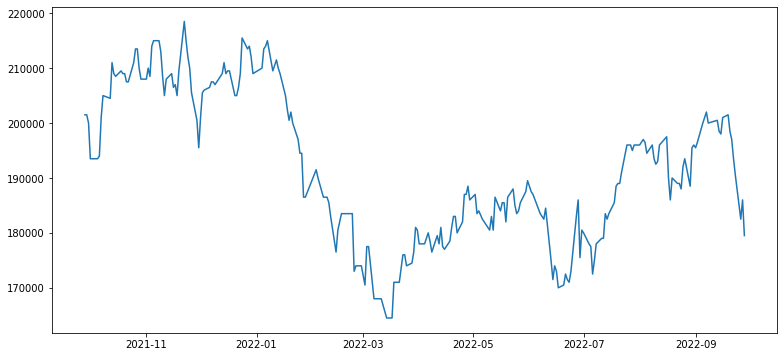

In [35]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 13, 6

plt.plot(hyundai)

STEP 2 : 각종 전처리 수행

In [36]:
# 결측치 처리

hyundai = hyundai.interpolate(method='time')
hyundai[hyundai.isna()] # 결측치 없음

Series([], Name: Close, dtype: float64)

In [37]:
# 로그 변환
hyundai_log = np.log(hyundai)
hyundai_log

Date
2021-09-28    12.213545
2021-09-29    12.213545
2021-09-30    12.206073
2021-10-01    12.173033
2021-10-05    12.173033
                ...    
2022-09-22    12.173033
2022-09-23    12.157407
2022-09-26    12.114505
2022-09-27    12.133502
2022-09-28    12.097930
Name: Close, Length: 246, dtype: float64

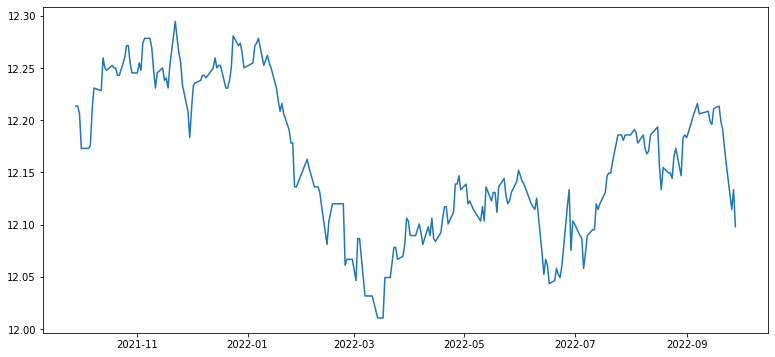

In [38]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 13, 6

plt.plot(hyundai_log)

STEP 3 : 시계열 안정성 분석
- 정성적 그래프 분석
- 정량적 Augmented Dicky-Fuller Test
- 시계열 분해(Time Series Decomposition)
- Residual 안정성 확인

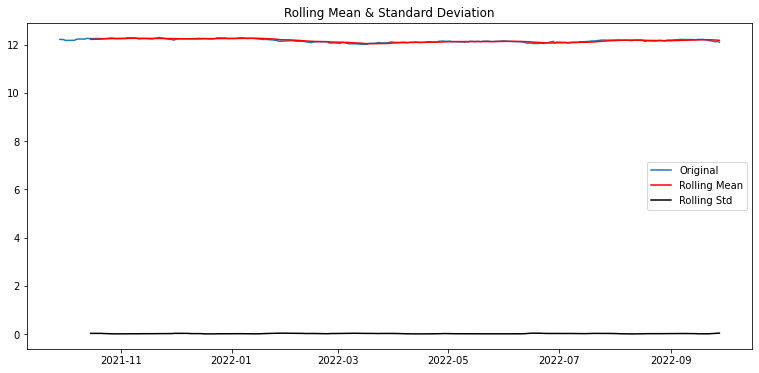

Results of Dickey-Fuller Test:
Test Statistic                  -1.548628
p-value                          0.509334
#Lags Used                       2.000000
Number of Observations Used    243.000000
Critical Value (1%)             -3.457551
Critical Value (5%)             -2.873509
Critical Value (10%)            -2.573148
dtype: float64


In [39]:
# 정성적 그래프 분석
plot_rolling_statistics(hyundai_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(hyundai_log)

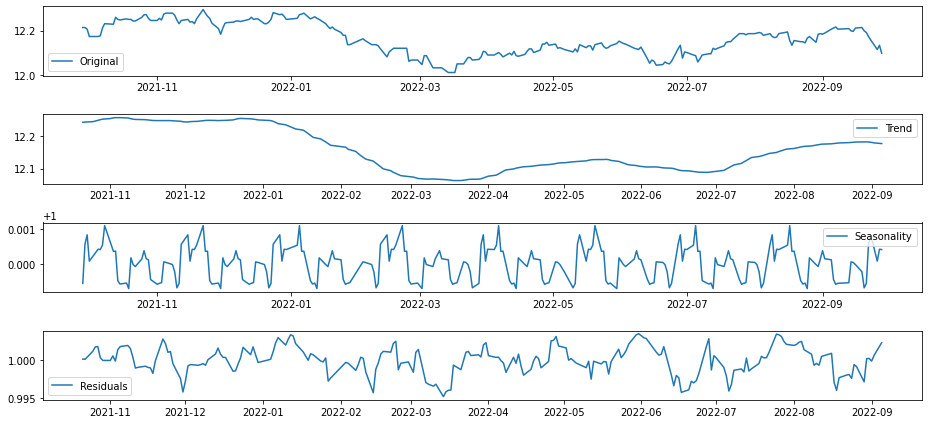

In [40]:
#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(hyundai_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(hyundai_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [41]:
# Residual 안정성 확인

residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                  -4.945456
p-value                          0.000028
#Lags Used                       3.000000
Number of Observations Used    212.000000
Critical Value (1%)             -3.461578
Critical Value (5%)             -2.875272
Critical Value (10%)            -2.574089
dtype: float64


STEP 4 : 학습, 테스트 데이터셋 생성

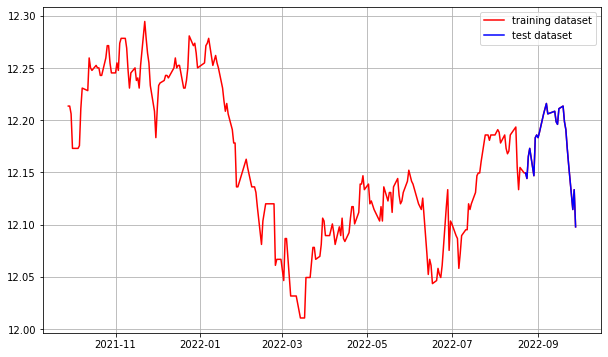

In [42]:
train_data, test_data = hyundai_log[:int(len(hyundai_log)*0.9)], hyundai_log[int(len(hyundai_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(hyundai_log, c='r', label='training dataset')
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

STEP 5 : 적정 ARIMA 모수 찾기
- ACF, PACF 그려보기 -> p,q 구하기
- 차분 안정성 확인 -> d 구하기

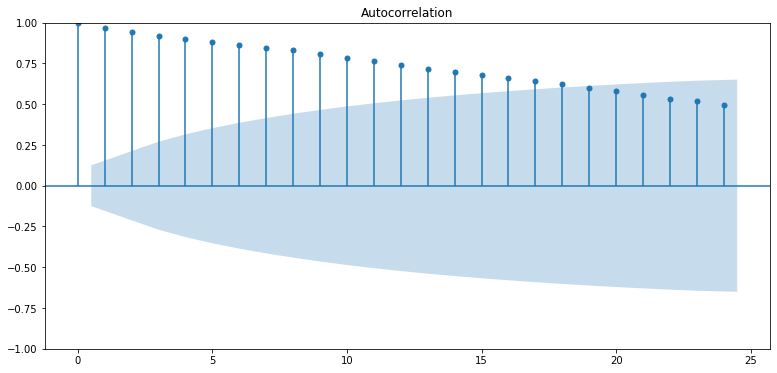

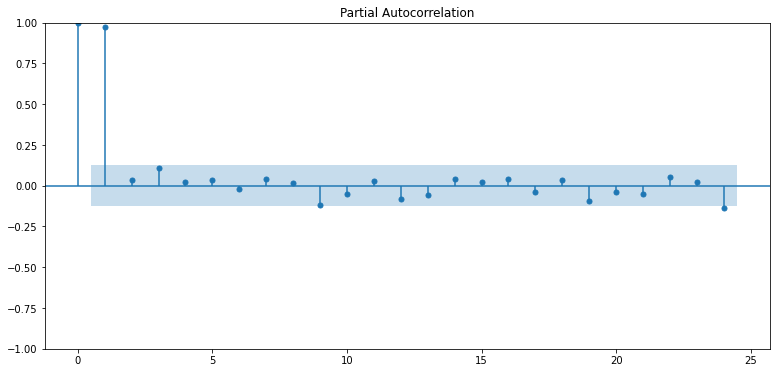

In [43]:
# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(hyundai_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(hyundai_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

- q = 1, p = 1

Results of Dickey-Fuller Test:
Test Statistic                -1.247742e+01
p-value                        3.145690e-23
#Lags Used                     1.000000e+00
Number of Observations Used    2.430000e+02
Critical Value (1%)           -3.457551e+00
Critical Value (5%)           -2.873509e+00
Critical Value (10%)          -2.573148e+00
dtype: float64


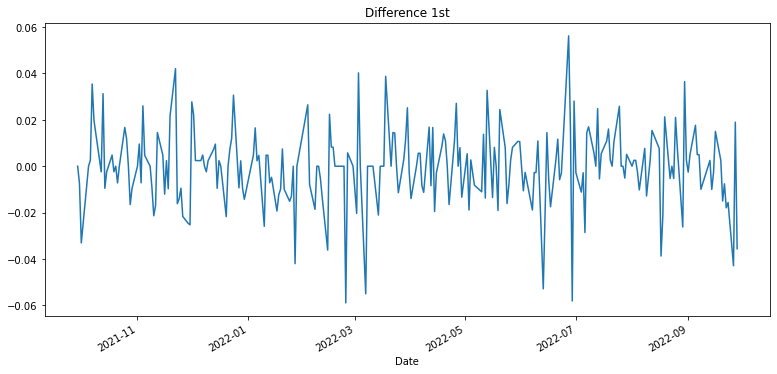

In [44]:
# 차분 안정성 확인 -> d 구하기

# 1차 차분 구하기
diff_1 = hyundai_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

- 1차 차분만으로도 p-value가 충분히 작음. 2차 차분을 하면 p-value 값이 올라감.

STEP 6 : ARIMA 모델 훈련과 테스트
- ARIMA 모델 빌드와 훈련
- 모델 테스트 및 플로팅
- 최종 예측 모델 정확도 측정(MAPE)

In [45]:
from statsmodels.tsa.arima.model import ARIMA
# Build Model
model = ARIMA(train_data, order=(1, 1, 1))
fitted_m = model.fit()

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  221
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 592.782
Date:                Thu, 29 Sep 2022   AIC                          -1179.563
Time:                        13:54:38   BIC                          -1169.382
Sample:                             0   HQIC                         -1175.452
                                - 221                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7246      0.177     -4.085      0.000      -1.072      -0.377
ma.L1          0.8220      0.146      5.623      0.000       0.536       1.109
sigma2         0.0003   1.81e-05     14.780      0.0

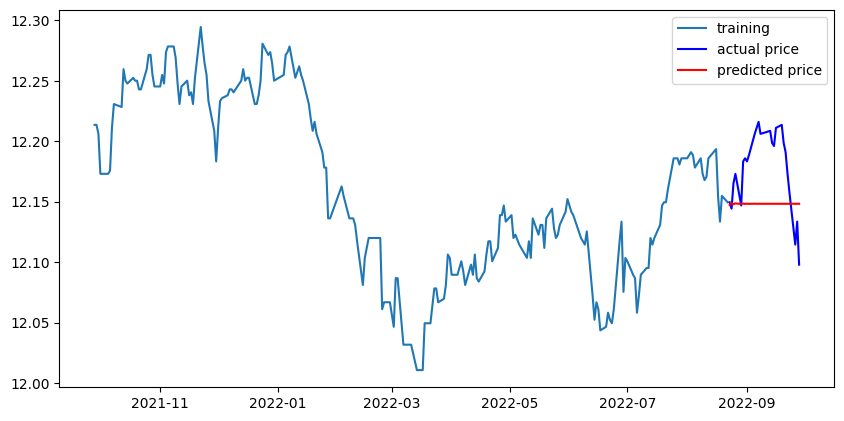

In [46]:
# Forecast
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [47]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  70575427.19993784
MAE:  7371.483590301447
RMSE:  8400.9182355227
MAPE: 3.75%


### 3. The Coca-Cola Company (KO)
STEP 1 : 시계열 데이터 준비

In [48]:
csv_path = os.getenv('HOME') + '/aiffel/stock_prediction/data/'
KO = pd.read_csv(csv_path+'KO.csv', index_col='Date', parse_dates=True)
KO = KO['Close']
KO

Date
2021-09-27    53.610001
2021-09-28    52.639999
2021-09-29    52.959999
2021-09-30    52.470001
2021-10-01    53.020000
                ...    
2022-09-21    59.400002
2022-09-22    59.259998
2022-09-23    58.599998
2022-09-26    57.869999
2022-09-27    56.380001
Name: Close, Length: 253, dtype: float64

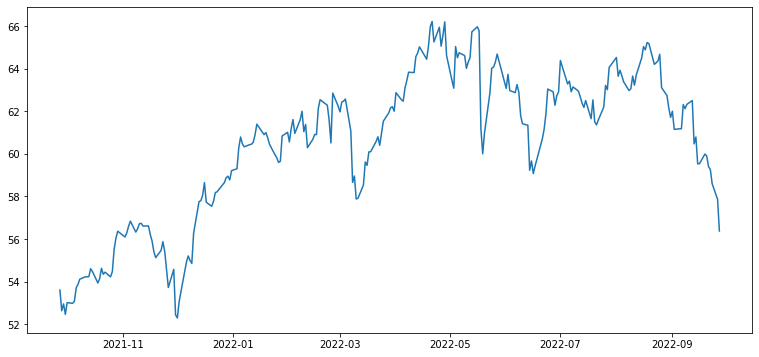

In [49]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 13, 6

plt.plot(KO)

STEP 2 : 각종 전처리 수행

In [50]:
# 결측치 처리

KO = KO.interpolate(method='time')
KO[KO.isna()] # 결측치 없음

Series([], Name: Close, dtype: float64)

In [51]:
# 로그 변환
KO_log = np.log(KO)
KO_log

Date
2021-09-27    3.981736
2021-09-28    3.963476
2021-09-29    3.969537
2021-09-30    3.960242
2021-10-01    3.970669
                ...   
2022-09-21    4.084294
2022-09-22    4.081935
2022-09-23    4.070735
2022-09-26    4.058199
2022-09-27    4.032115
Name: Close, Length: 253, dtype: float64

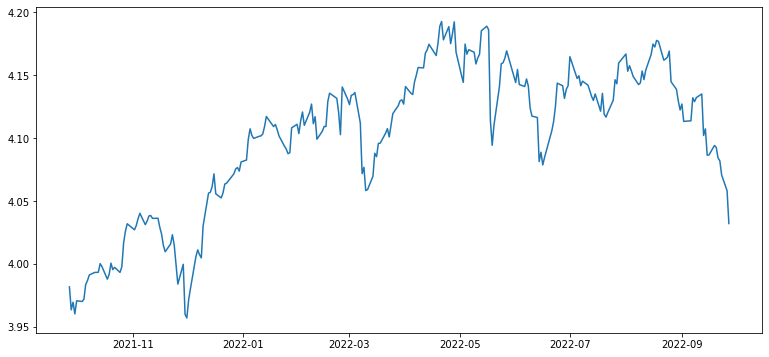

In [52]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 13, 6

plt.plot(KO_log)

STEP 3 : 시계열 안정성 분석
- 정성적 그래프 분석
- 정량적 Augmented Dicky-Fuller Test
- 시계열 분해(Time Series Decomposition)
- Residual 안정성 확인

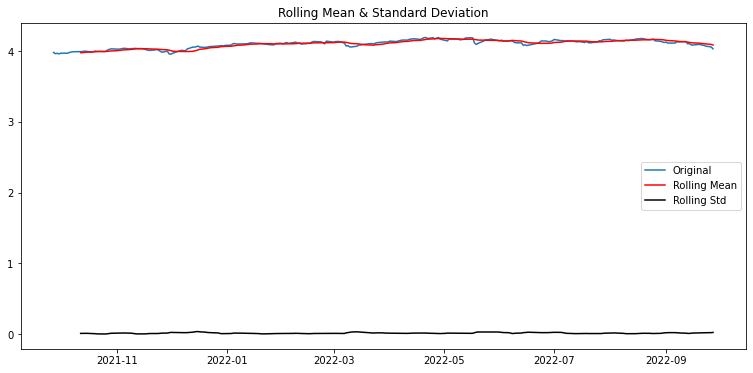

Results of Dickey-Fuller Test:
Test Statistic                  -2.049298
p-value                          0.265385
#Lags Used                       0.000000
Number of Observations Used    252.000000
Critical Value (1%)             -3.456569
Critical Value (5%)             -2.873079
Critical Value (10%)            -2.572919
dtype: float64


In [53]:
# 정성적 그래프 분석
plot_rolling_statistics(KO_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(KO_log)

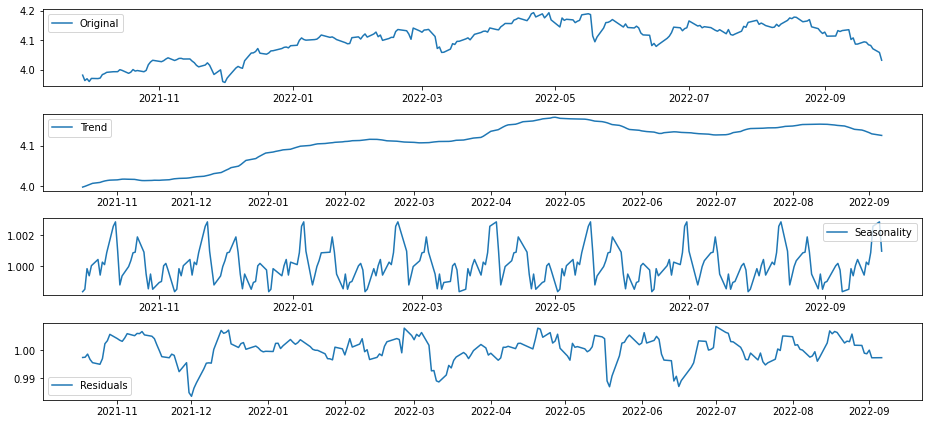

In [54]:
#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(KO_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(KO_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [55]:
# Residual 안정성 확인

residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                  -5.548731
p-value                          0.000002
#Lags Used                       2.000000
Number of Observations Used    220.000000
Critical Value (1%)             -3.460428
Critical Value (5%)             -2.874769
Critical Value (10%)            -2.573821
dtype: float64


STEP 4 : 학습, 테스트 데이터셋 생성

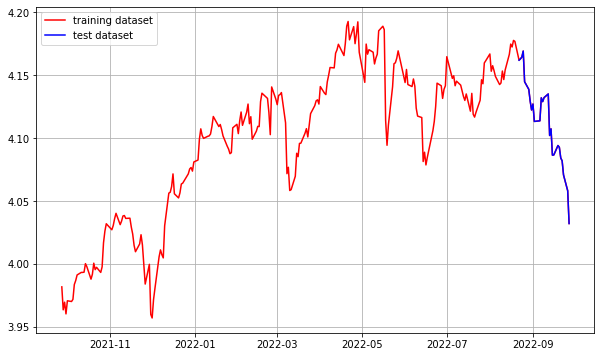

In [56]:
train_data, test_data = KO_log[:int(len(KO_log)*0.9)], KO_log[int(len(KO_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(KO_log, c='r', label='training dataset')
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

STEP 5 : 적정 ARIMA 모수 찾기
- ACF, PACF 그려보기 -> p,q 구하기
- 차분 안정성 확인 -> d 구하기

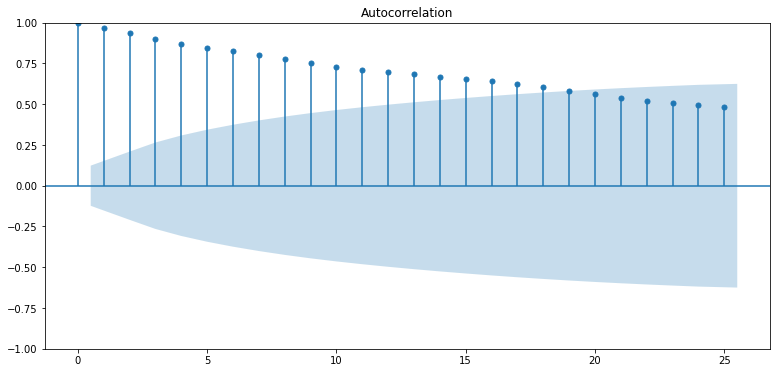

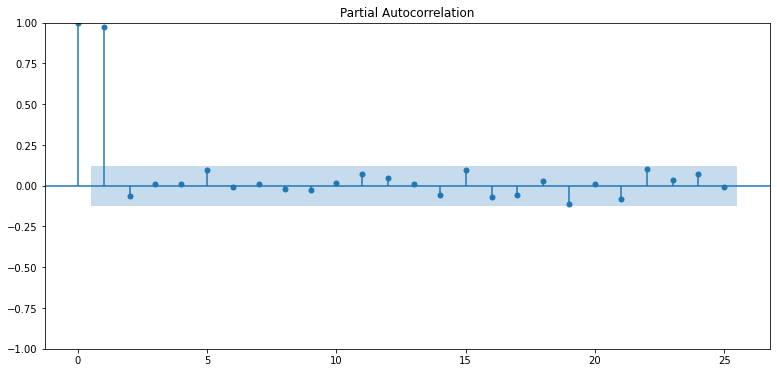

In [57]:
# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(KO_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(KO_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

- q = 1, p = 1

Results of Dickey-Fuller Test:
Test Statistic                -1.495645e+01
p-value                        1.258004e-27
#Lags Used                     0.000000e+00
Number of Observations Used    2.510000e+02
Critical Value (1%)           -3.456674e+00
Critical Value (5%)           -2.873125e+00
Critical Value (10%)          -2.572944e+00
dtype: float64


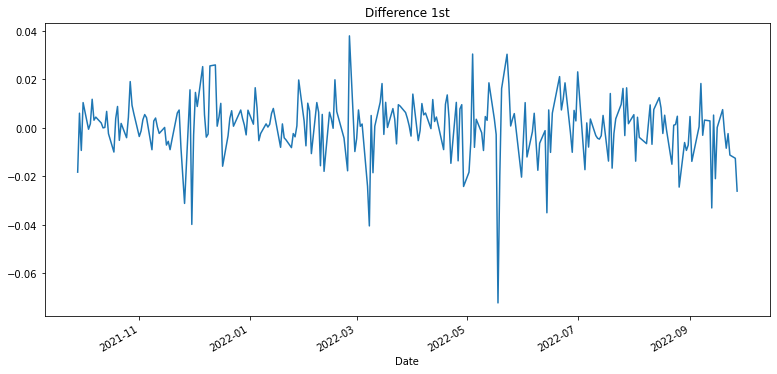

In [58]:
# 차분 안정성 확인 -> d 구하기

# 1차 차분 구하기
diff_1 = KO_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

- 1차 차분만으로도 충분히 p-value 값이 작음

STEP 6 : ARIMA 모델 훈련과 테스트
- ARIMA 모델 빌드와 훈련
- 모델 테스트 및 플로팅
- 최종 예측 모델 정확도 측정(MAPE)

In [59]:
from statsmodels.tsa.arima.model import ARIMA
# Build Model
model = ARIMA(train_data, order=(1, 0, 1)) # (1, 1, 1)보다 d=0일 때 MAPE의 값이 적음
fitted_m = model.fit() 

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  227
Model:                 ARIMA(1, 0, 1)   Log Likelihood                 675.908
Date:                Thu, 29 Sep 2022   AIC                          -1343.816
Time:                        13:54:41   BIC                          -1330.116
Sample:                             0   HQIC                         -1338.288
                                - 227                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.0977      0.023    176.014      0.000       4.052       4.143
ar.L1          0.9709      0.012     80.274      0.000       0.947       0.995
ma.L1          0.0655      0.062      1.053      0.2

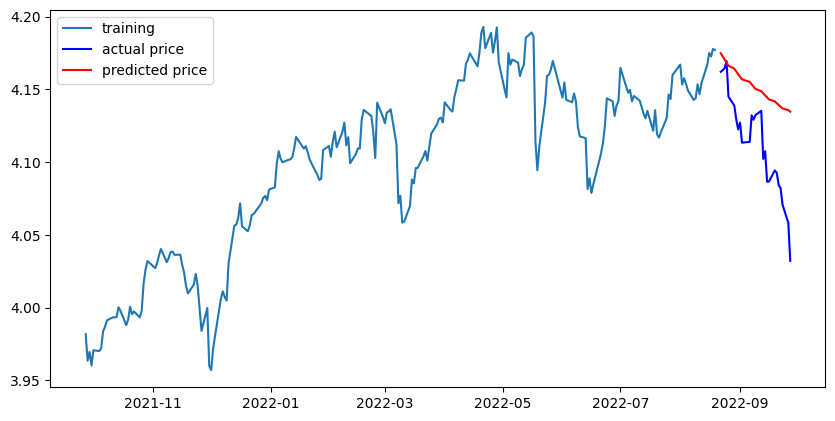

In [60]:
# Forecast
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [61]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  7.390423384181078
MAE:  2.3410735658908006
RMSE:  2.718533314892624
MAPE: 3.90%


### 회고 작성
1. 이번 프로젝트에서 **어려웠던 점.**
- 안정적인 시계열인지 확인하는 방법인 ADF Test에서 귀무가설, 대립가설의 관계를 이해하는 것이 어려웠다. p-value가 낮을수록 안정적인 데이터라고 했는데, 반대로 p-value 값이 1에 가깝다는 사실은 귀무가설(시계열이 안정적이지 않다)이 옳다는 직접적인 증거는 아니라는 점이 이해가 안 되었다. p-value가 1에 가까우면 귀무가설이 옳다는 것은 아니지만 시계열이 안정적이지 않을 확률이 높다는 방향으로 이해하면 되는 것 같다.
2. 프로젝트를 진행하면서 **알아낸 점** 혹은 **아직 모호한 점**.
- 예측 그래프와 실제 그래프는 차이가 있었는데도 MAPE 값이 낮게 나왔다. 그래프 상으로는 예측값과 정답값이 차이가 있는데도 왜 손실함수 값은 낮게 나오는지 궁금하다.
- 코카콜라 주가 예측에서 p-value의 값은 원래 상태보다 1차 차분 후 작게 나왔다. 그러나 ARIMA 모델에서 q, p 값과의 조합에서는 차분을 하지 않은 경우가 MAPE 값이 낮게 나왔다. 세 파라미터 간 최적의 조합을 찾는 것이 아직 모호한 것 같다.
3. 루브릭 평가 지표를 맞추기 위해 **시도한 것들**.
- ARIMA 모델을 이용하여 3개 종목의 주식에 주가 예측을 진행하였다. 그 과정에서 ACF, PACF와 차분을 이용하여 파라미터를 조절하였다.
4. 만약에 루브릭 평가 관련 지표를 **달성 하지 못했을 때, 이유에 관한 추정**.
- 시계열이 안정적인지 시각화하고 그에 대한 설명을 충분히 서술하여야 했는데, 그 설명이 충분하지 않았을 것 같다.
5. **자기 다짐.**
- 공분산, 상관계수, 자기상관계수 같은 통계 지식을 학습할 필요성을 느꼈다.